In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [4]:
df = pd.read_pickle('/Users/linggeli/microscope/images.pkl')

In [5]:
df.head()

,empty,v0,alpha,defocus,astig_mag,astig_angle,Cs,C5,HAADF,BF
0,[0],200.0,25.0,0.0,3.0,218.0,0.0,0.0,"[[6077.966383437542, 5873.16598480453, 5286.27...","[[38935261.03899363, 38935916.2752696, 3893782..."
1,[0],200.0,25.0,0.0,-32.0,7.0,0.0,0.0,"[[2030.4218178851645, 2007.284605339987, 1914....","[[38949127.667159565, 38949200.809813626, 3894..."
2,[0],200.0,25.0,0.0,-14.0,236.0,0.0,0.0,"[[4974.975770298894, 4816.746670931963, 4364.0...","[[38939046.17134134, 38939542.93186685, 389410..."
3,[0],200.0,25.0,0.0,25.0,19.0,0.0,0.0,"[[3108.4082221742615, 3015.2100062369936, 2774...","[[38945446.15357177, 38945744.81940919, 389465..."
4,[0],200.0,25.0,0.0,-48.0,105.0,0.0,0.0,"[[598.4442089536583, 600.7411240792431, 621.22...","[[38953970.32038059, 38953948.98710649, 389538..."


In [6]:
X_images = np.zeros((300, 128, 128))

In [7]:
for i in range(300):
    X_images[i, :, :] = df['HAADF'][i]

In [8]:
img = X_images[4, :56:2, :56:2]
print(img.shape)

(28, 28)


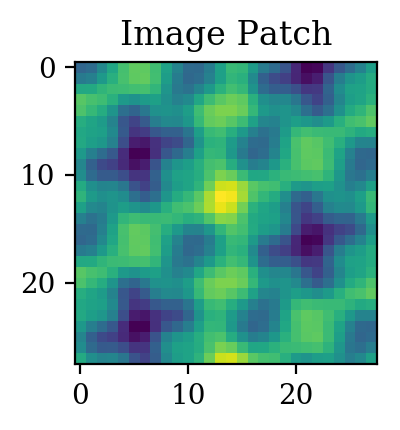

In [10]:
fig = plt.figure(figsize=(2, 2), dpi=200)
plt.imshow(img)
plt.title('Image Patch')
plt.show()

(28, 28)


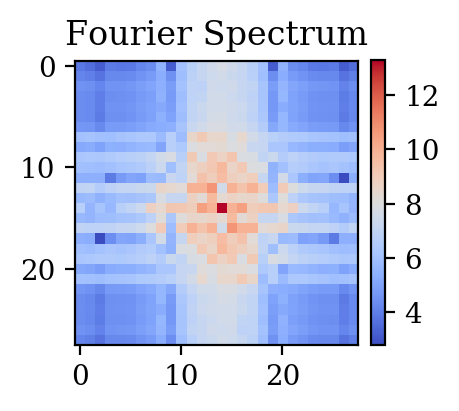

In [13]:
fig = plt.figure(figsize=(2, 2), dpi=200)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
spectrum = np.log(np.abs(fshift))
plt.imshow(spectrum, cmap='coolwarm')
print(spectrum.shape)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Fourier Spectrum')
plt.show()

In [14]:
X_fourier = np.zeros((300, 28, 28))
for i in range(300):
    img = X_images[i, :56:2, :56:2]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    spectrum = np.log(np.abs(fshift))
    X_fourier[i, :, :] = spectrum

In [15]:
X_fourier_scaled = (X_fourier - np.mean(X_fourier)) / np.std(X_fourier)

In [16]:
y_angle = df['astig_angle'].values

In [17]:
y_label = np.ceil((y_angle % 180) / 20)
y_label[y_label == 0] = 1

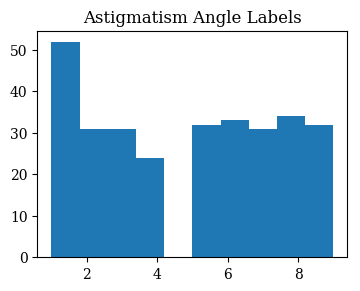

In [18]:
#print(np.min(y_label))
#print(np.max(y_label))
fig = plt.figure(figsize=(4, 3), dpi=100)
plt.hist(y_label.flatten())
plt.title('Astigmatism Angle Labels')
plt.show()

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=10)
pca.fit(X_fourier_scaled.reshape((300, 28 * 28)))
print(pca.explained_variance_ratio_)  

[0.8762056  0.02691669 0.02003851 0.01862555 0.01091147 0.00633355
 0.00565408 0.00424426 0.00340875 0.00305333]


In [23]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [25]:
clf = LogisticRegressionCV(cv=10, solver='lbfgs', 
                           multi_class='multinomial').fit(X_fourier_scaled.reshape((300, 28 * 28)), y_label)

In [26]:
y_hat = clf.predict(X_fourier_scaled.reshape((300, 28 * 28)))
print(np.mean(y_hat == y_label))

0.6733333333333333


In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
matrix = confusion_matrix(y_label, y_hat)
print(matrix)

[[49  0  0  0  2  1  0  0  0]
 [ 4 21  0  0  0  3  3  0  0]
 [ 5  0 16  0  0  0  0 10  0]
 [ 4  0  0 11  0  0  0  4  5]
 [12  0  0  0 17  0  0  0  3]
 [10  2  0  0  0 21  0  0  0]
 [ 1  7  3  0  0  4 16  0  0]
 [ 4  0  2  1  0  0  0 26  1]
 [ 4  0  0  2  0  0  0  1 25]]


Normalized confusion matrix


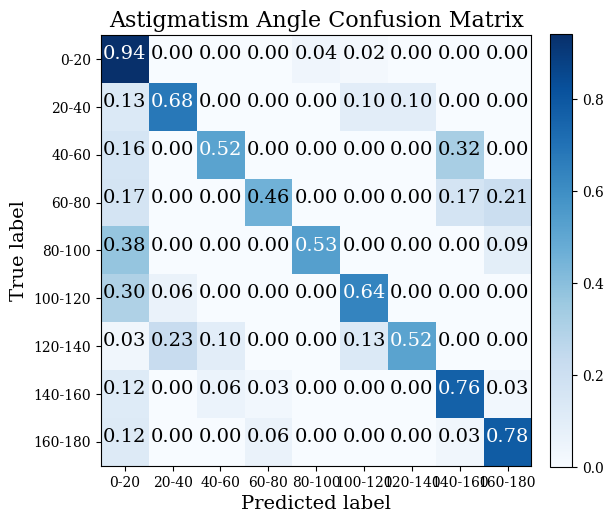

In [32]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plot_confusion_matrix(matrix, 
                      classes=['0-20', '20-40', '40-60', '60-80', '80-100', 
                               '100-120', '120-140', '140-160', '160-180'],
                      normalize=True,
                      title='Astigmatism Angle Confusion Matrix')
plt.show()

In [30]:
import itertools

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)